`WUR Machine Learning Course - Assignment 1 - Version 2022`

# Regional crop yield prediction

In this exercise, we investigate the problem of regional crop
yield prediction. 
Crop yield prediction is an important but complex problem, 
as crop yield forecasts are valuable to several stakeholders in the agrifood chain. 
Crop yield is influenced by environmental conditions, agricultural management decisions, and many crop-specific parameters.


It is difficult to build a reliable and explainable forecasting model, especially at a regional scale. 
More about using machine learning for regional crop forecasting see the work of [*Paudel et al.* (2021)](http://dx.doi.org/10.1016/j.agsy.2020.103016).


In this assignment, you will employ **regression models** to forecast early season crop yields for all Dutch provinces. To predict regional crop yields you will use spatio-temporal  [open data](https://zenodo.org/record/4312941) from the European Commission’s Joint Research Center (JRC). Data cover all 11 Dutch provinces for the years 2010-2022. 


Your task is to predict crop yields for potato using **simple linear regression, and K-Nearest Neighbors Regression**. In the process, you will investigate which features contribute the most to the prediction models and which algorithm performs better!

## Data description

The original data have been preprocessed to obtain features (or predictor variables) and labels (or target variables). 
Data have been also split in two sets: the training set, that includes to the years from 1999-2011, and the test set, that corresponds to the period 2012-2018.

There are the following 25 columns in the dataset:

- **2 identifier columns** `IDREGION`, `FYEAR` Each row reports crop yields for the corresponding year and region. Note that these columns are not to be used as features, rather for reporting and visualization.
- **1 static feature**, i.e. a feature that does not change year over the years. There is only one such feature, soil water holding capacity (`SM_WHC`) characterizing the region soil properties.
- **21 weather, remote sensing and crop-related features**, that are further explained below.
- **Yield label**, the target yield values for your prediction tasks are included in YIELD.





## Weather, remote sensing and crop-related features 

### Weather-related variables
The weather features provides are aso derived from several weather indicators:

- `TAVG` average daily air temperature ($^\circ C$)
- `PREC` sum of daily precipitation ($mm$)
- `ET0`  sum of daily evapotranspiration of short vegetation (Penman-Monteith, Allen et al., 1998) (mm))
- `RAD`  sum of daily global incoming shortwave radiation (KJ m-2 d-1)
- `CWB`  climate water balance, calculated as precipitation minus sum of daily evapotranspiration

### Remote-sensing related variables
Furthermore, a remote sensing indicator called `FAPAR` (Fraction of Absorbed Photosynthetically Active Radiation, see Copernicus Global Land Service, 2020) was also used.


### Crop-related variables
For these features, you need some background on the crop simulation model called WOFOST. The World Food Studies (WOFOST) crop model ([van Diepen *et al.*, 1989](https://doi.org/10.1111/j.1475-2743.1989.tb00755.x)) is a simulation model for the quantitative analysis of the growth and development of annual field crops. It is a mechanistic, dynamic model that explains daily crop growth based on the underlying processes, such as photosynthesis and how these processes are influenced by environmental conditions. The crop simulation runs using weather, soil and crop data. 

The model has two modes: 

i. potential production limited only by radiation, temperature, atmospheric CO2 concentration and crop characteristics; and  
ii. water limited production where growth limitations due to water availability also play a role ([de Wit *et al.*  2019](https://doi.org/10.1016/j.agsy.2018.06.018)).

WOFOST features provided are based on the following WOFOST outputs:

-	`WLIM_YB` water-limited dry weight biomass ($kg/ha$)
-	`WLIM_YS` water-limited dry weight storage organs ($kg/ha$)
-	`WLAI` water-limited leaf area divided by surface area ($m^2/m^2$)
-	`RSM` root-zone soil moisture as a percentage of soil water holding capacity
-	`TWC` sum of water limited transpiration ($cm$)


### Feature design

The above variables are reported for various periods during a crop growing season.

We used the development stage (0-200) output of WOFOST to infer different periods of the crop growing season. The table below, summarizes the crop calendar periods and the indicators used to design features. 

Two types of features were designed: (i) maximum values for accumulative indicators (e.g., water-limited yield biomass), and (ii) average values for other indicators.


| Period|Maximum value|Average value|
|:-:|:-:|:-:|
Pre-planting window (p0)| | TAVG, PREC, CWB  | 
Planting window (p1)| | TAVG, PREC |	RSM, TMIN, PREC
Vegetative phase (p2)	  | WLIM_YB, TWC, WLAI | RSM, TAVG, CWB, FAPAR, RAD | 	
Flowering phase (p3)|  | PREC |
Yield Formation phase (p4)|	WLIM_YB, WLIM_YS, TWC, WLAI |	RSM, CWB, FAPAR, RAD |
Harvest window (p5)	 |  | PREC	|

Based on Table above, you will be able to understand what each of the following feature names represent: `avgTAVGp0`, `maxWLIM_YBp2`.

The first one, `avgTAVGp0`, is the average daily air temperature (`TAVG`) average for the pre-planting window (`p0`). 

Second, `maxWLIM_YBp2` is the maximum value of  water-limited dry weight biomass(`WLIM_YB`) in the vegetative phase (`p2`).

## Environment setup
Install and import packages and functions needed for the project.

In [ ]:
%pip install geopandas --quiet

In [ ]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from statistics import mean

In [ ]:
seed=42 
np.random.seed(seed)

## Load data to colab

As it is web-based, Colab notebooks cannot read your local files. We therefore copy the data from a server


In [ ]:
! [ ! -d 'yield_data' ] && git clone https://gist.github.com/3206e24244286dd25efd9e8bb39f079e.git yield_data 

Check the data folder of your notebook. There should be a new folder created with the name yield_data that contains two csv files.

# Assignement Overview

In this exercise, we will learn how to use two different models to perform regression:

- **Linear model** 

  The goal is to find the coefficients $\beta_i$ of the equation: 
  
  $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$
  
  where $Y$ is the variable to predict (crop yields in our case), and $Xi$ are the predictor variables. 
   <!-- So in the exercise, we have N = 62 (as we have 62 bands). -->
   This corresponds to the chapter 3.2 of the textbook. 

- **KNN**

   This is a simple non-parametric approach to regression. Here, $Y$ is predicted by averaging the values of the $K$ nearest neighbors to $X$. In the book, this approach is described in chapter 3.5.

To evaluate and compare our models, we will use several metrics: 
the Root Mean Square Error (RMSE, chapter 2.2.1), Mean Absolute Error (MAE) and the coefficient of determination ($R^2$, chapter 3.1.3).

Make sure that you have studied the above chapters before you continue.







# Exercise 1: Read the dataset, and visualy explore it
*See Section 2.3.4 in the book*

In this exercise we will visually explore the potato dataset.

Load both the training and test datasets for potato, and then answer the questions that follow.

In [ ]:
train = pd.read_csv("yield_data/potato_NL_train.csv", sep=",")
test  = pd.read_csv("yield_data/potato_NL_test.csv",  sep=",")

> ## Question 1.1
> Plot the histogram for the target variable (`YIELD`) for both the training and test datasets.
>    - Add a comment on comparing the two plots.
>

<AxesSubplot: xlabel='YIELD', ylabel='Count'>

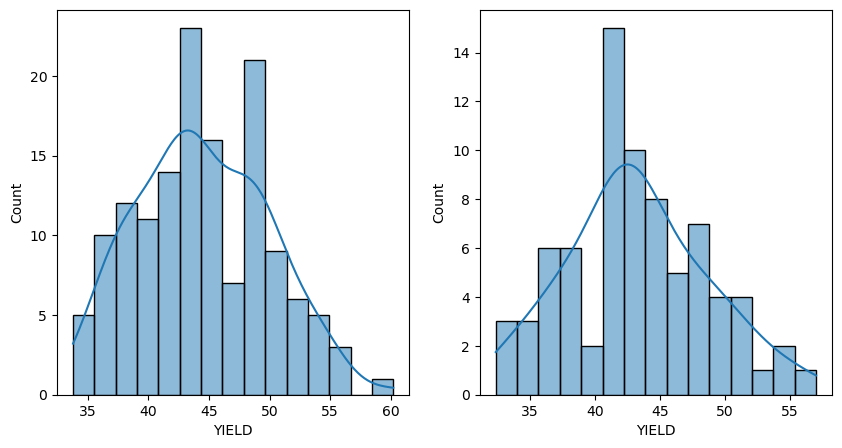

In [ ]:
# TODO: Your code here
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))

sns.histplot(data = train, ax = axes[0], x = 'YIELD', bins = 15, kde = True)
sns.histplot(data = test, ax = axes[1], x = 'YIELD', bins = 15, kde = True)

TODO: The histograms indicate that both roughly follow a normal distribution, the test set more so than the training set. The training set has a mean of around 44-45, whereas the test dataset has a mean of around 43-44. 

> ## Question 1.2
> Calculate summary statistics for potato yields, in both training and test split.
>    - Interprete the summary statistics.


In [ ]:
# TODO: Your code here

pd.DataFrame([train.YIELD.describe(), test.YIELD.describe()], index = ['Yield_train', 'Yield_test'])

,count,mean,std,min,25%,50%,75%,max
Yield_train,143.0,44.497902,5.386753,33.8,40.55,44.0,48.3,60.2
Yield_test,77.0,43.232468,5.426529,32.4,39.40,42.7,46.4,57.0


TODO: Add your interpretation of the summary statistics

We see that there are a total of 220 observations in the dataset ranging from 1999 to 2018. However, the dataset is split into training and testing. The former has 143 observations from 1999 to 2011, while the latter has 77 observations from 2012 to 2018. This makes one observation per province per year. 

The test dataset has a lower average YIELD than the training dataset, as well as a high standard deviation, fitting with the fact that there are less observations in the test dataset. In addition, the median for the training set is also slightly higher. Also, the training set has a slightly larger range than the test set, 33.8-60.2 and 32.4-57.0, respectively. 

> ## Question 1.3 (Optional) 
>
> Plot a boxplot diagram of yields as a function of year for both training and test data.
>  - What do you derive from this plot?


<AxesSubplot: xlabel='FYEAR', ylabel='YIELD'>

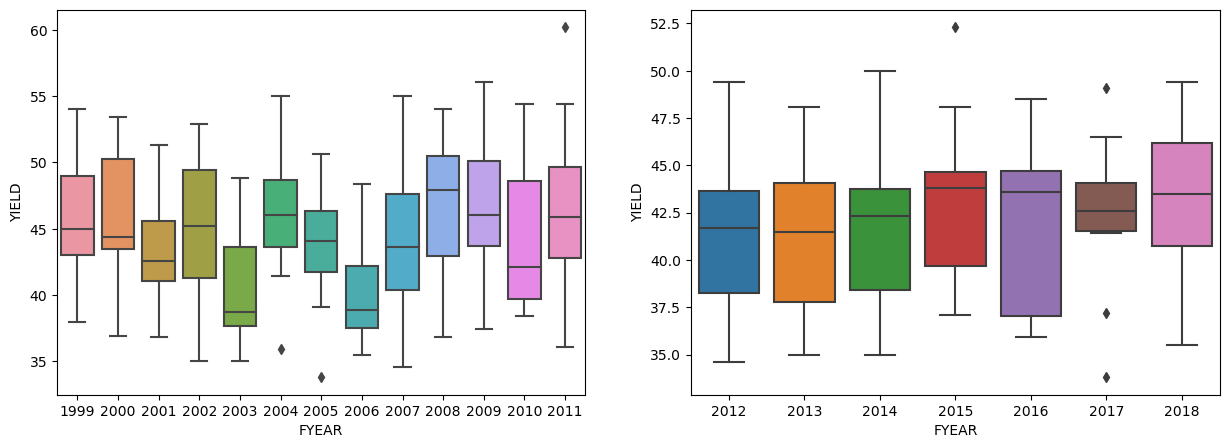

In [ ]:
# TODO: Your code here
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

sns.boxplot(x = train.FYEAR, y = train.YIELD, data = train, ax = axes[0])
sns.boxplot(x = test.FYEAR, y = train.YIELD, data = test, ax = axes[1])

TODO: Your comments here

We observe that the average yield in the test data tends to increase as time progresses from 2012 to 2018 and is in a more stable trend over time than the average yield in the training data. The training data is very unstable and there is not really a trend as time progresses. Additionally, the maximum yield observations are lower in the test dataset than in the training dataset. This is inline with the summary statistics as obtained previously. Finally, there seem to be more outliers in the test data. 

> ## Question 1.4. 
> Visually inspect the relationship using scatterplots, between `YIELD` and:  
>  
>   a. average FAPAR in periods p2 and p4, i.e. 'avgFAPARp2', 'avgFAPARp4'.  
>   b. average precipitation in periods p0, p3 and p5, i.e. `avgPRECp0`, `avgPRECp3`, `avgPRECp5`.
>   - Comment on the two visualizations produced in this exercise.
>

<AxesSubplot: xlabel='avgPRECp5', ylabel='YIELD'>

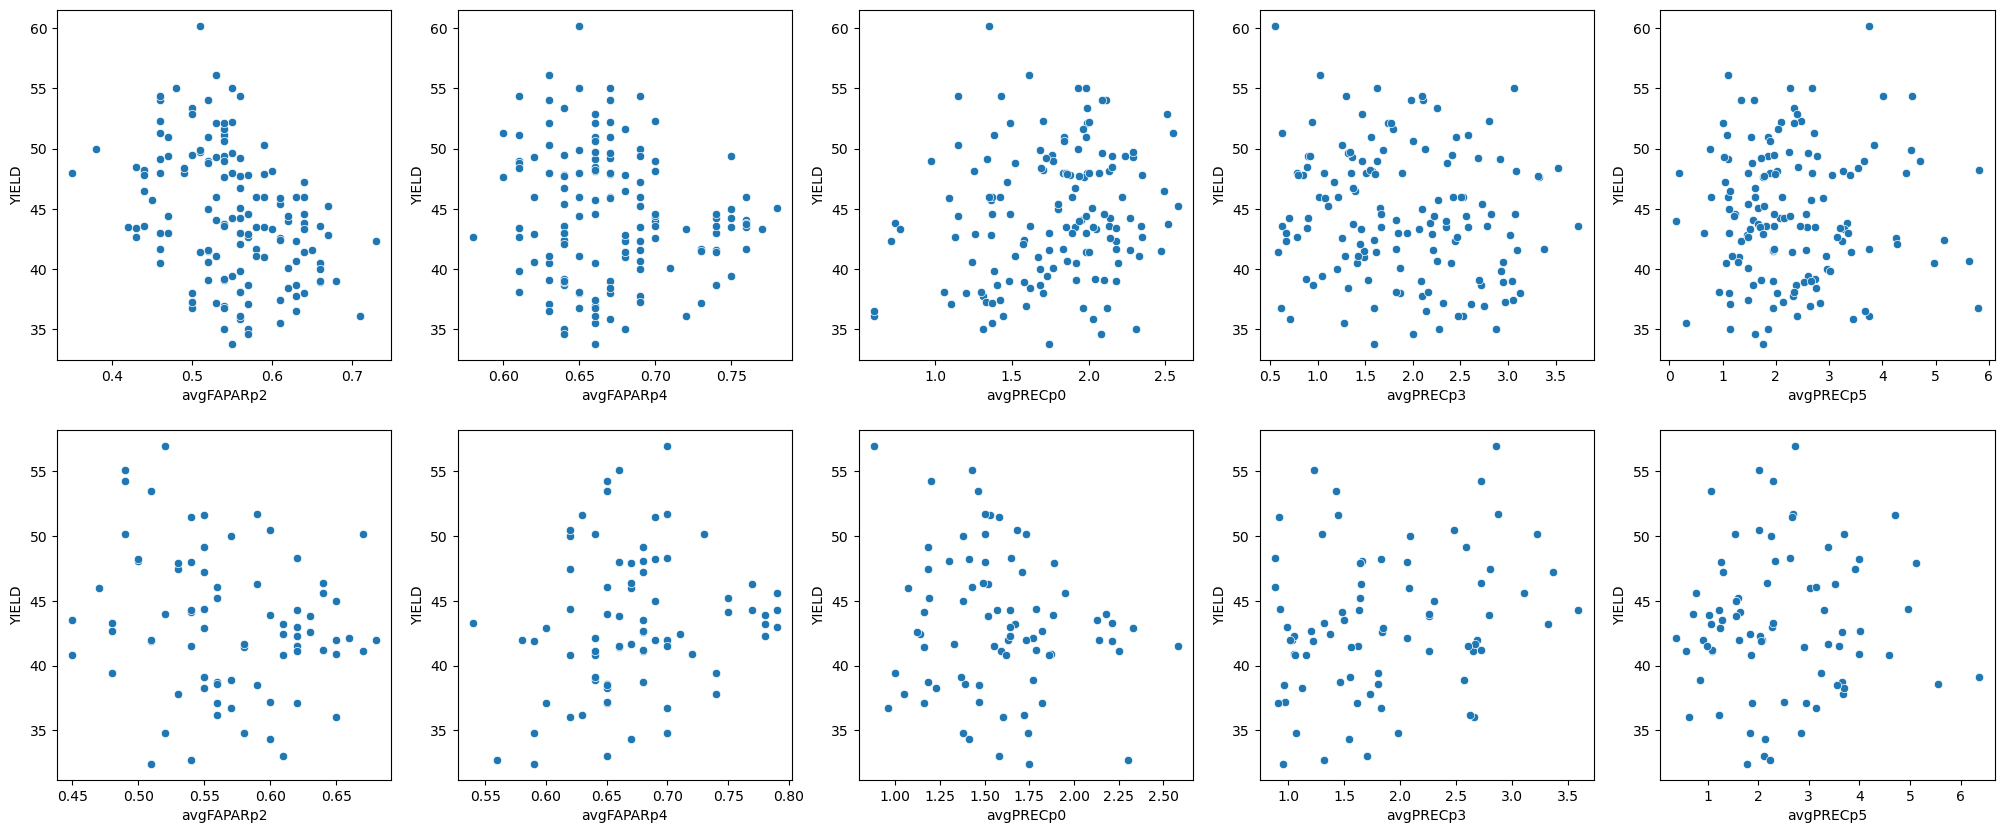

In [ ]:
# TODO: Your code here
fig, axes = plt.subplots(2, 5, figsize = (25, 10))

sns.scatterplot(x = 'avgFAPARp2', y = 'YIELD', data = train, ax = axes[0,0])
sns.scatterplot(x = 'avgFAPARp4', y = 'YIELD', data = train, ax = axes[0,1])
sns.scatterplot(x = 'avgPRECp0', y = 'YIELD', data = train, ax = axes[0,2])
sns.scatterplot(x = 'avgPRECp3', y = 'YIELD', data = train, ax = axes[0,3])
sns.scatterplot(x = 'avgPRECp5', y = 'YIELD', data = train, ax = axes[0,4])

sns.scatterplot(x = 'avgFAPARp2', y = 'YIELD', data = test, ax = axes[1,0])
sns.scatterplot(x = 'avgFAPARp4', y = 'YIELD', data = test, ax = axes[1,1])
sns.scatterplot(x = 'avgPRECp0', y = 'YIELD', data = test, ax = axes[1,2])
sns.scatterplot(x = 'avgPRECp3', y = 'YIELD', data = test, ax = axes[1,3])
sns.scatterplot(x = 'avgPRECp5', y = 'YIELD', data = test, ax = axes[1,4])

TODO: Add your comments here. 

The scatterplots don't show any clear correlation between the predictors and the response variable. 


> ## Question 1.6 (Optional) 
> Continue exploring the data, and provide a brief summary of what you discover.

In [ ]:
# TODO: Your code here
train.corr()

/var/folders/3n/skyhwqyn5yz2d_5hhct269lm0000gn/T/ipykernel_1826/1366877826.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,FYEAR,SM_WHC,maxWLIM_YBp2,maxTWCp2,maxWLAIp2,maxWLIM_YBp4,maxWLIM_YSp4,maxTWCp4,maxWLAIp4,avgRSMp2,...,avgTAVGp1,avgPRECp1,avgTAVGp2,avgCWBp2,avgPRECp3,avgCWBp4,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
FYEAR,1.000000e+00,-8.360170e-14,0.036556,0.117297,-0.048704,0.002831,0.063361,0.136195,-0.320119,-0.180642,...,-0.064630,-0.333392,-0.215758,-0.231815,-0.016544,0.359413,0.236983,0.324883,0.028536,0.033111
SM_WHC,-8.360170e-14,1.000000e+00,0.244606,0.248565,0.224684,0.352165,0.315910,0.420775,0.287183,0.119438,...,0.009873,0.109865,-0.003357,0.028440,0.048711,0.109940,-0.032040,0.099173,0.719887,-0.212658
maxWLIM_YBp2,3.655623e-02,2.446060e-01,1.000000,0.985127,0.973711,0.271514,0.232185,0.195170,0.236625,-0.413158,...,0.506537,-0.049156,0.274864,-0.060557,0.131633,0.417029,0.032732,0.456568,0.271124,-0.414746
maxTWCp2,1.172974e-01,2.485646e-01,0.985127,1.000000,0.950407,0.307398,0.279101,0.248033,0.186463,-0.462949,...,0.465389,-0.071548,0.279125,-0.146474,0.080969,0.446506,0.033264,0.471226,0.307668,-0.367082
maxWLAIp2,-4.870397e-02,2.246839e-01,0.973711,0.950407,1.000000,0.239785,0.195411,0.156266,0.285117,-0.379196,...,0.553597,0.000483,0.354580,-0.030770,0.166618,0.353395,-0.021190,0.423097,0.262939,-0.402684
maxWLIM_YBp4,2.830750e-03,3.521653e-01,0.271514,0.307398,0.239785,1.000000,0.987220,0.956626,0.157747,-0.005795,...,0.266255,-0.154276,0.266473,-0.233192,0.000439,0.646517,-0.049519,0.151396,0.514683,0.083632
maxWLIM_YSp4,6.336108e-02,3.159098e-01,0.232185,0.279101,0.195411,0.987220,1.000000,0.944994,0.019833,-0.042483,...,0.249538,-0.175213,0.270490,-0.288709,-0.053825,0.677422,-0.026087,0.155746,0.495163,0.110405
maxTWCp4,1.361952e-01,4.207754e-01,0.195170,0.248033,0.156266,0.956626,0.944994,1.000000,0.182109,0.050754,...,0.161034,-0.147952,0.189619,-0.260707,-0.044670,0.642596,0.000457,0.161641,0.555303,0.136373
maxWLAIp4,-3.201188e-01,2.871829e-01,0.236625,0.186463,0.285117,0.157747,0.019833,0.182109,1.000000,0.422991,...,0.078901,0.289519,0.010081,0.455920,0.462380,-0.069154,-0.071062,0.010329,0.219706,-0.247989
avgRSMp2,-1.806421e-01,1.194376e-01,-0.413158,-0.462949,-0.379196,-0.005795,-0.042483,0.050754,0.422991,1.000000,...,-0.051490,0.393170,-0.053154,0.604678,0.453149,-0.269987,-0.159478,-0.176351,-0.041729,0.018293


TODO: 

There aren't any noticeable correlations between YIELD and the predictors. However, some of the crop-related variables were found to correlate with each other, such as the water-limited leaf area and the water limited transpiration. These make sense because plants. 

# Exercise 2: Linear models
*See Section 3.6.2 in the book*

In this exercise, we will train a linear model with the yield data, and evaluate it using several measures. 

The aim is to create a model that is independent of location and year, rather is uses weather, remote sensing and crop modelling features as predictors.

First, remove from your training and test data, the identifier columns, i.e. region name and year.

In [ ]:
X_train = train.drop(columns=["IDREGION","FYEAR",'YIELD'])
y_train = train['YIELD']

X_test = test.drop(columns=["IDREGION","FYEAR",'YIELD'])
y_test = test['YIELD']

> ## Question 2.1
> Train a linear model with your training data, using the function `smf.ols(...).fit()`
>



Tip: use `join` to create the function formula you want, as below: 

```formula = 'YIELD ~ ' + '+'.join(X_train.columns)```


In [ ]:
formula = 'YIELD ~ ' + '+'.join(X_train.columns)
formula

'YIELD ~ SM_WHC+maxWLIM_YBp2+maxTWCp2+maxWLAIp2+maxWLIM_YBp4+maxWLIM_YSp4+maxTWCp4+maxWLAIp4+avgRSMp2+avgRSMp4+avgTAVGp0+avgPRECp0+avgCWBp0+avgTAVGp1+avgPRECp1+avgTAVGp2+avgCWBp2+avgPRECp3+avgCWBp4+avgPRECp5+avgFAPARp2+avgFAPARp4'

In [ ]:
# TODO: Your code here
mlr_model = smf.ols(formula, data=train).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  YIELD   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     8.761
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           3.82e-16
Time:                        10:32:35   Log-Likelihood:                -374.72
No. Observations:                 143   AIC:                             795.4
Df Residuals:                     120   BIC:                             863.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       43.2900     14.542      2.977      0.004      14.497      72.083
SM_WHC         -15.2349     14.768     -1.032      0.304     -44.474      14.004
maxWLIM_YBp2    -0.0101      0.004     -2.446      0.016      -0.018      -0.002
maxTWCp2         4.9995      2.480      2.016      0.046       0.090       9.909
maxWLAIp2        0.5275      1.456      0.362      0.718      -2.356       3.411
maxWLIM_YBp4     0.0001      0.002      0.074      0.941      -0.004       0.004
maxWLIM_YSp4    -0.0035      0.002     -1.820      0.071      -0.007       0.000
maxTWCp4         2.8159      0.456      6.176      0.000       1.913       3.719
maxWLAIp4       -4.3196      1.735     -2.490      0.014      -7.754      -0.885
avgRSMp2        -0.0339      0.030     -1.113      0.268      -0.094       0.026
avgRSMp4        -0.0894      0.091     -0.987      0.326      -0.269       0.090
avgTAVGp0        3.5483      0.743      4.777      0.000       2.078       5.019
avgPRECp0      -15.2829      4.766     -3.207      0.002     -24.719      -5.847
avgCWBp0        11.9618      4.238      2.823      0.006       3.571      20.352
avgTAVGp1        1.3404      0.644      2.080      0.040       0.064       2.616
avgPRECp1        0.6670      1.053      0.633      0.528      -1.419       2.753
avgTAVGp2       -0.2981      0.587     -0.508      0.612      -1.460       0.864
avgCWBp2         1.7666      0.971      1.820      0.071      -0.156       3.689
avgPRECp3       -0.9663      0.870     -1.111      0.269      -2.689       0.757
avgCWBp4        -0.1339      2.228     -0.060      0.952      -4.545       4.278
avgPRECp5        1.3454      0.476      2.828      0.005       0.404       2.287
avgFAPARp2     -25.9033      5.668     -4.570      0.000     -37.125     -14.681
avgFAPARp4       4.4392     13.141      0.338      0.736     -21.579      30.457
==============================================================================
Omnibus:                        0.556   Durbin-Watson:                   1.452
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.487
Skew:                          -0.142   Prob(JB):                        0.784
Kurtosis:                       2.965   Cond. No.                     1.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> ## Question 2.2
>  Check the coefficients of the model. 
> Which are the most significant? What does the signs of the coefficients mean? 
>  -  Explain below.



The most significant predictors are maxTWCp4, avgTAVGp0, avgFAPARp2. They have a very low p value of around 0.000. Other significant variables are: maxWLIM_YBp2, maxTWCp2, maxWLAIp4, avgPRECp0, avgCWBp0, avgTAVGp1, and avgPRECp5.
Some of the most insignificant predictors are maxWLIM_YBp4, avgCWBp4, avgFAPARp4. All other predictors not yet mentioned are insignificant as well.

The signs tell us something about direction of change in YIELD for a one unit change for a predictor. So for example, a positive sign indicates that Yield is positively affected (goes up) by a one unit increase in the predictor. On the contrary, a negative sign indicates that Yield is negatively affected (goes down) by a one unit increase in the predictor. 

> ## Question 2.3
>  What is the $R^2$  reported for training? 

In [ ]:
# TODO: Your code here
print('R-squared: ', mlr_model.rsquared)
print('Ajd. R-squared: ', mlr_model.rsquared_adj)

R-squared:  0.6163038660050209
Ajd. R-squared:  0.545959574772608


As can be seen above, the model obtained an R-squared of 0.62. Its adjusted R-squared is lower though, 0.55. It makes sense that the adjusted R-squared is lower since this metric accounts for the complexity of the model. Since our model is quite complex with 22 independent variables, it is quite complex and thus a lower adjusted R-squared is expected.

> ## Question 2.4
> Apply the linear model for making predictions with the test data. 
> Report RMSE, MAE and R2 metrics for both training and test sets. 
>  - Comment your results below.

Tip: Use scikit-learn functions from the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Check the documentation of MSE for reporting RMSE - see the `squared` parameter.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TODO: Your code here

# Making Prediction
y_pred_test = mlr_model.predict(X_test)
y_pred_train = mlr_model.predict(X_train)

# Evaluating Predictor on Test Data
print("Assessment Test Model")
print("MAE = ", mean_absolute_error(y_true = y_test, y_pred = y_pred_test))
print("RMSE = ", mean_squared_error(y_true = y_test, y_pred = y_pred_test))
print("R-squared = ", r2_score(y_true = y_test, y_pred = y_pred_test)) 

# Evaluating Predictor on Train Data
print("Assessment Train Model")
print("MAE = ", mean_absolute_error(y_true = y_train, y_pred = y_pred_train))
print("RMSE = ", mean_squared_error(y_true = y_train, y_pred = y_pred_train))
print("R-squared = ", r2_score(y_true=y_train, y_pred=y_pred_train)) 

mlr_assessment = pd.DataFrame({'Model': ['Test', 'Train'], 
                               'MAE': [mean_absolute_error(y_true = y_test, y_pred = y_pred_test), mean_absolute_error(y_true = y_train, y_pred = y_pred_train)],
                               'RMSE': [mean_squared_error(y_true = y_test, y_pred = y_pred_test), mean_squared_error(y_true = y_train, y_pred = y_pred_train)],
                               'R-squared': [r2_score(y_true = y_test, y_pred = y_pred_test), r2_score(y_true=y_train, y_pred=y_pred_train)]})
mlr_assessment


Assessment Test Model
MAE =  5.326556401893122
RMSE =  40.149746918317305
R-squared =  -0.3813878200168781
Assessment Train Model
MAE =  2.6569219103551385
RMSE =  11.055893845523459
R-squared =  0.6163038660050209


,Model,MAE,RMSE,R-squared
0,Test,5.326556,40.149747,-0.381388
1,Train,2.656922,11.055894,0.616304


As expected, the training model performs better than the testing model. This can be seen through a lower RMSE and MAE. Also, the R-squared of the testing model is negative, which indicates that we are dealing with an arbitrarily worse model, according to the Sckit-Learn documentation. 

It makes sense for the training model to be a better performer, since it its trained on its own data and thus needs to predict the response for data this it is already familiar with. The test data however, it completely new data and thus it is more difficult for the model to predict the response correctly.

> # Question 2.5. 
> Visualize your model predictions in the test set vs. the observed values.


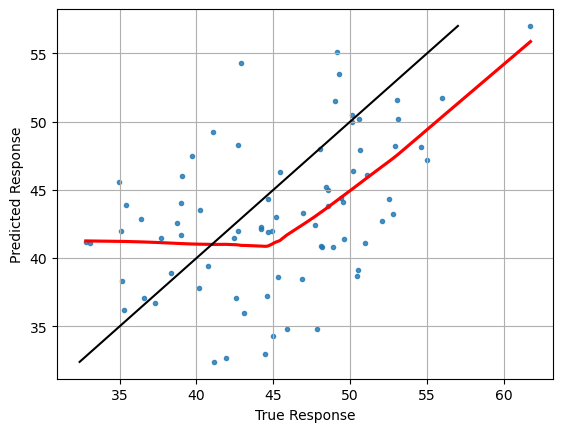

In [ ]:
# TODO: Your code here

## This function plots an abline for the model y = ax + b in the interval [x_min,x_max]
def plot_abline(a, b, x_min, x_max, color = 'r', linestyle = '-'):
  plt.plot([x_min, x_max], [a*x_min+b, a*x_max+b], color=color, linestyle=linestyle)

# Make the plot with all data points and the fitted linear model y = ax + b
sns.regplot(y=y_test, x=y_pred_test, marker='.', lowess=True, line_kws={"color": 'red'})
plot_abline(1, 0, y_test.min(), y_test.max(), color='black')
plt.grid()
plt.ylabel('Predicted Response')
plt.xlabel('True Response')
plt.show()


In the plot above, we can see that the model did not do a really good job. If the model would have been perfect, the scatterplot would have shown all dots on the black line, since the predicted response would be equal to the observed response. Therefore, a visual like this allows us to quickly see the performance of the model and where it makes mistakes. As can be seen, our model does not predict the response well, as was expected with an R-squared value of -0.38. However, it can be seen that it is consistantly bad. It could have been the case that our model is bad because it predicts responses bad in a certain subrange, but this is not the case as it has a low performance for the whole range of values. 

# Exercise 3: K-Nearest Neighbors for regression
*See Section 3.5 in the book*

In this assignment we will use the function `KNeighborsRegressor()` from the library sklearn. In the practical, you have used `KNeighborsClassifier()` which is used for classification, but for continous values like predicting yield we use the `KNeighborsRegressor()` function which is for regression.




> # Question 3.1
> What value for K would you guess being reasonable? 
>
> Train a KNN regression model for this value, and evaluate its performance in the test set using the metrics used for the linear model.
>  - Comment the scores of the KNN model and compare to the ones previously obtained by the linear model.


TODO: Add here your guess for K!
We estimate that a K = 3 would likely fit this data. We think this because a lower K would likely fit here because of the large number of predictors. Also, as we know due to the curse of dimensionality, the probability of finding observations near are small. Therefore, a very high K would likely result in a worse model since the neighbors are too far away to obtain an accurate prediction.

In [ ]:
# TODO: Your code here
# Fit the model
knn_model = KNeighborsRegressor(n_neighbors = 3).fit(X_train, y_train)

# Run model on test dataset (get predictions)
knn_pred = knn_model.predict(X_test)

# Evaluate performance of model
print("Assessment KNN Model K = 3")
print("MAE = ", mean_absolute_error(y_true = y_test, y_pred = knn_pred))
print("RMSE = ", mean_squared_error(y_true = y_test, y_pred = knn_pred))
print("R-squared =", r2_score(y_true=y_test, y_pred=knn_pred)) 

knn_assess = pd.DataFrame({'Model': ['KNN (K = 3)', 'Linear'], 
                           'MAE': [mean_absolute_error(y_true = y_test, y_pred = knn_pred), mean_absolute_error(y_true = y_test, y_pred = y_pred_test)],
                           'RMSE': [mean_squared_error(y_true = y_test, y_pred = knn_pred), mean_squared_error(y_true = y_test, y_pred = y_pred_test)],
                           'R-squared': [r2_score(y_true=y_test, y_pred=knn_pred), r2_score(y_true = y_test, y_pred = y_pred_test)]})
knn_assess


Assessment KNN Model K = 3
MAE =  4.1307359307359315
RMSE =  25.673448773448783
R-squared = 0.11668211743348733


,Model,MAE,RMSE,R-squared
0,KNN (K = 3),4.130736,25.673449,0.116682
1,Linear,5.326556,40.149747,-0.381388


TODO: How does this compare with teh linear model

Assessment Test Model: 
MAE =  5.326556401893122
RMSE =  40.149746918317305
R-squared =  -0.3813878200168781

When comparing the KNN model to the linear model, we see that the KNN model has lower RMSE and MAE values as well as a higher R squared. These metrics all indicate a better fit of the KNN model than the linear model to the dataset. 

> ## Question 3.2
>  We will now tune the (hyper)parameter of the model (K). 
> 
> This means you will loop (use for()) the KNN with different values of K and retain the one that gives the best performances (cross-validation, chapter 5.1). 
>
> We will use the ‘validation set approach’ (chapter 5.1.1, take a moment to read it), i.e. we will sacrify part of our training samples to find K.

> Run the KNN by using as training samples the first 110 samples of the training set and the remaining 33 samples of the training set as validation set.   **Do not use the test set here, otherwise you will bias your final results!** Pick the best k, based on the performance on the validation set.   
>
>   - 2a. What range of values would be suitable for K in this problem?  
>   
>   - 2b. Report your best k, your metrics and comment.  




TODO: Comment on what is a suitable range for K in this problem

We believe K should be limited to small values as the observation dataset is small compared to the large number of predictors, and also due to the curse of dimensionality as explained earlier. We therefore test models with K ranging from 1 to 10. 

     K       MAE       RMSE        R2
0    1  6.427273  68.637273 -2.660326
1    2  6.533333  63.165303 -2.368514
2    3  6.419192  59.103535 -2.151906
3    4  6.518939  60.559678 -2.229560
4    5  6.403030  57.313564 -2.056449
5    6  6.457071  58.838106 -2.137751
6    7  6.452381  56.776988 -2.027835
7    8  6.560227  58.079560 -2.097299
8    9  6.586195  57.261680 -2.053683
9   10  6.615455  58.225579 -2.105086
10  11  6.595317  57.327350 -2.057185
11  12  6.676263  58.188190 -2.103092
12  13  6.829371  60.217798 -2.211328
13  14  6.912771  61.286780 -2.268335
14  15  6.910101  61.359180 -2.272196


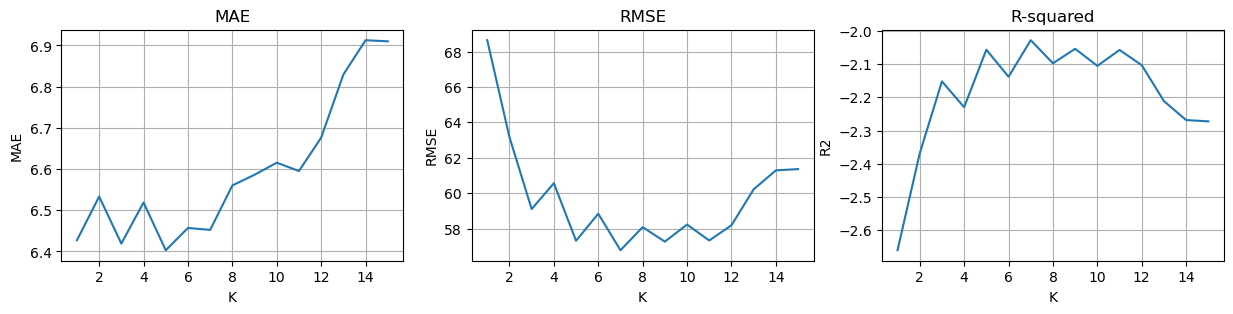

In [ ]:
# Little help with slicing the dataset :)
X_train110 = X_train.iloc[:110]
y_train110 = y_train.iloc[:110]

X_validation = X_train.iloc[110:]
y_validation = y_train.iloc[110:]

# Make list for metrics as input for DF
k_list = []
mae_list = []
rmse_list = []
r_list = []

for i in range(1,16): 
  knn_model = KNeighborsRegressor(n_neighbors = i).fit(X_train110, y_train110)
  knn_pred = knn_model.predict(X_validation)
  k_list += [i]
  mae_list += [mean_absolute_error(y_true = y_validation, y_pred = knn_pred)]
  rmse_list += [mean_squared_error(y_true = y_validation, y_pred = knn_pred)]
  r_list += [r2_score(y_true=y_validation, y_pred=knn_pred)]

# Make df of metrics
performance_df = pd.DataFrame({'K': k_list, 'MAE': mae_list, 'RMSE': rmse_list, 'R2': r_list}, columns = ['K', 'MAE', 'RMSE', 'R2'])
print(performance_df)

# Make plot of metrics
fig, axes = plt.subplots(ncols = 3, figsize = (15,3))

sns.lineplot(x= 'K', y='MAE', data=performance_df, ax=axes[0])
axes[0].set_title("MAE")
axes[0].grid()

sns.lineplot(x='K', y="RMSE", data=performance_df, ax=axes[1])
axes[1].set_title("RMSE")
axes[1].grid()

sns.lineplot(x='K', y="R2", data=performance_df, ax=axes[2])
axes[2].set_title("R-squared")
axes[2].grid()


TODO: Report your besk K, and metrics!

As can be seen in our plots, K = results in the lowest MAE, namely approximately 6.4. However, when looking at the RMSE, we see that K = 7 results in the lowest RMSE. At last, when looking at the R-squared, we see that K = 7 returns the highest R-squared.

Based on the cross-validation, we see that K = 7 return the best performance metrics as it has the lowest RMSE and the highest R2. K = 5 could also be a second option as its RMSE and R2 are second best and it has the lowest MAE. 

> ## Question 3
> Once you identified a good value for k, train your model using the full training set and evaluate its performance for the test set. 
> 
> ### Question 3a
> - Report the evaluation metrics, and compare with linear regression.



In [ ]:
# Fit the model
knn_model_7 = KNeighborsRegressor(n_neighbors = 7).fit(X_train, y_train)

# Run model on test dataset (get predictions)
knn_pred_7 = knn_model_7.predict(X_test)

# Evaluate performance of model
print("Assessment KNN Model K = 7")
print(mean_absolute_error(y_true = y_test, y_pred = knn_pred_7))
print(mean_squared_error(y_true = y_test, y_pred = knn_pred_7))
print(r2_score(y_true=y_test, y_pred=knn_pred_7)) 



# Fit the model
knn_model_5 = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

# Run model on test dataset (get predictions)
knn_pred_5 = knn_model_5.predict(X_test)

# Evaluate performance of model
print("Assessment KNN Model K = 5")
print(mean_absolute_error(y_true = y_test, y_pred = knn_pred_5))
print(mean_squared_error(y_true = y_test, y_pred = knn_pred_5))
print(r2_score(y_true=y_test, y_pred=knn_pred_5)) 

knn_assessment = pd.DataFrame({'Model': ['KNN (K = 5)', 'KNN (K = 7)', 'Linear'], 
                               'MAE': [mean_absolute_error(y_true = y_test, y_pred = knn_pred_5), mean_absolute_error(y_true = y_test, y_pred = knn_pred_7), mean_absolute_error(y_true = y_test, y_pred = y_pred_test)],
                               'RMSE': [mean_squared_error(y_true = y_test, y_pred = knn_pred_5), mean_squared_error(y_true = y_test, y_pred = knn_pred_7), mean_squared_error(y_true = y_test, y_pred = y_pred_test)],
                               'R-squared': [r2_score(y_true=y_test, y_pred=knn_pred_5), r2_score(y_true=y_test, y_pred=knn_pred_7), r2_score(y_true = y_test, y_pred = y_pred_test)]})
knn_assessment

Assessment KNN Model K = 7
4.301855287569573
28.521905645375032
0.01867842050539703
Assessment KNN Model K = 5
4.326753246753248
27.836716883116896
0.04225295044008037


,Model,MAE,RMSE,R-squared
0,KNN (K = 5),4.326753,27.836717,0.042253
1,KNN (K = 7),4.301855,28.521906,0.018678
2,Linear,5.326556,40.149747,-0.381388


Assessment Test Model
MAE =  5.326556401893122
RMSE =  40.149746918317305
R-squared =  -0.3813878200168781

As can be seen, both KNN models perform better than the linear model based on all three metrics. 

What is interesting, however, is that K = 7 now performs worse on all metrics than K= 5. This is probably because the K = 7 model fitted better to the validation data, but when tested against test data this fit performe worse.

> Question 3b 
> - Make a scatter plot of the predictions of the KNN and linear model against the observed yields. 


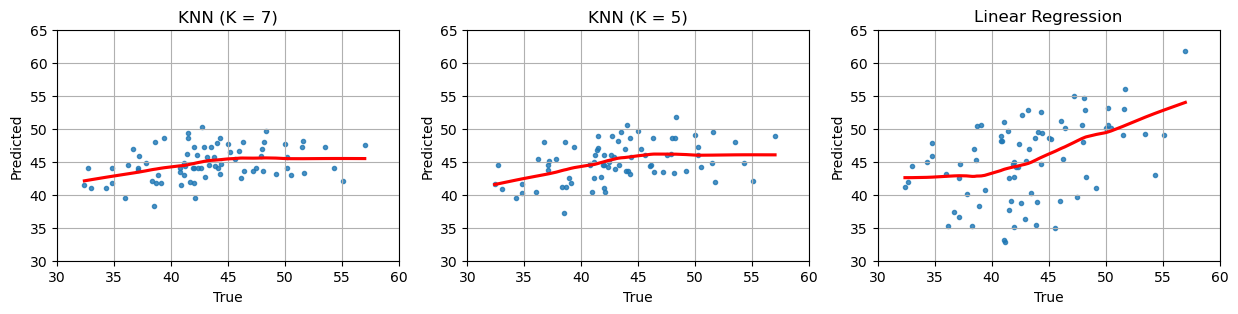

In [ ]:
# TODO: Your code here
fig, axes = plt.subplots(ncols = 3, figsize = (15,3))

sns.regplot(x = y_test, y = knn_pred_7, marker = '.', lowess = True, line_kws = {'color' : 'red'}, ax = axes[0])
axes[0].set_title('KNN (K = 7)')
axes[0].set_ylabel('Predicted')
axes[0].set_xlabel('True')
axes[0].set_xlim([30, 60])
axes[0].set_ylim([30, 65])
axes[0].grid()

sns.regplot(x = y_test, y = knn_pred_5, marker = '.', lowess = True, line_kws = {'color' : 'red'}, ax = axes[1])
axes[1].set_title('KNN (K = 5)')
axes[1].set_ylabel('Predicted')
axes[1].set_xlabel('True')
axes[1].set_xlim([30, 60])
axes[1].set_ylim([30, 65])
axes[1].grid()

sns.regplot(x = y_test, y = y_pred_test, marker = '.', lowess = True, line_kws = {'color' : 'red'}, ax = axes[2])
axes[2].set_title('Linear Regression')
axes[2].set_ylabel('Predicted')
axes[2].set_xlabel('True')
axes[2].set_xlim([30, 60])
axes[2].set_ylim([30, 65])
axes[2].grid()

plt.show()


What we see here is that for both KNN models, the plots have a different shape as compared to the linear model. As mentioned earlier, in on optimal situation, the plots would show a scatterplot with datapoints in a straightline, where x = y. However, our three models do not show this perfect plot, as was expected. BUt what is interesting though is that the red line for the KNN models flattens as observations get bigger, whereas the contrary is true for the linear model, which starts flattend out and slowly because sloped.

This indicates that for higher values, the KNN models think that there are, on average, diminishing returns. The linear model, however, thinks that the opposite is true, namely that there are no diminishing returns but that there is a certain lower boundary. 

> ### Question 3c  (optional)
> 
> Visualize a boxplot of the errors of the KNN and linear models. What do you observe?

    Linear Regression  KNN K = 5  KNN K = 7
0            5.310529       2.54   1.600000
1            0.615609      11.34  10.200000
2            9.854899       1.50   1.900000
3            0.679207      -0.92  -0.271429
4           -8.397768       4.86   3.100000
..                ...        ...        ...
72           4.717960      -8.04  -9.442857
73           0.365108      -4.12  -6.157143
74          -5.027001       6.52   3.900000
75          -5.976291     -12.98 -13.028571
76           2.936956       2.50   2.042857

[77 rows x 3 columns]


[Text(0, 0.5, 'Residuals')]

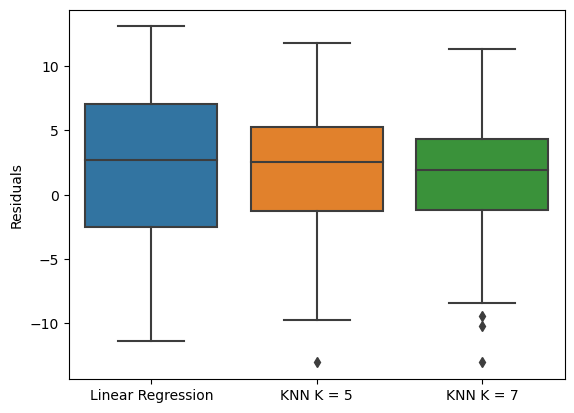

In [ ]:
# TODO: Your code here

mlr_resid = y_pred_test - y_test
knn_5_resid = knn_pred_5 - y_test
knn_7_resid = knn_pred_7 - y_test

model_residuals_df = pd.DataFrame([mlr_resid, knn_5_resid, knn_7_resid], index = ['Linear Regression', 'KNN K = 5', 'KNN K = 7']).T

print(model_residuals_df)

sns.boxplot(data= model_residuals_df).set(ylabel = 'Residuals')

In our boxplots, we can see that the range for the linear regression is highest. In addition, we see that the medians are roughly the same for all three models. Also, both KNN models show outliers. 

This indicates that the linear model experiences the highest mistakes, which can also be seen in the fact that it has the lowest R-squared, RMSE, and MAE. Also, here it is clearly visualised that the K = 7 and K = 5 are pretty similar in terms of results and why they show us mixed results in the three metrics. These mixed results can probably be explained by the observations that there are more outliers in the K = 7 model, despite its lower range and median.

# Exercise 4: Spatial visualization of errors (Optional)
*See the tutorial on NUTS visualization (MGI_W1_Visualization_goes_NUTS.ipynb)*





> ## Question 4.1. 
> - For both the linear and the KNN models, visualize in a map their errors for year 2012. 
 > -  Comment on your visualizations
   

<AxesSubplot: >

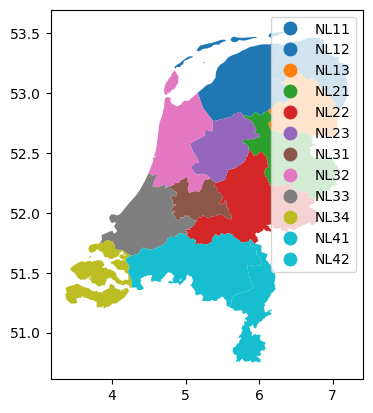

In [ ]:
# TODO: Your code here

# Import Geodata Europe
nuts_eu = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2016_4326_LEVL_2.geojson') 

# Make Geodata NL
nuts_nl = nuts_eu[nuts_eu["CNTR_CODE"]=="NL"]
nuts_nl.plot(nuts_nl["NUTS_ID"], legend=True)

In [ ]:
# Joining Datasets into Main Dataset
test_nl = pd.merge(nuts_nl, test[['IDREGION', 'FYEAR', 'YIELD']], left_on = 'NUTS_ID', right_on = "IDREGION")
test_nl.head()


,id,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,IDREGION,FYEAR,YIELD
0,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2012,42.4
1,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2013,36.7
2,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2014,41.1
3,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2015,42.0
4,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2016,41.2


In [ ]:
# Adding Residuals of Models to Main Dataset
test_nl = pd.concat([test_nl, model_residuals_df], axis = 1)
test_nl.head()


,id,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,IDREGION,FYEAR,YIELD,Linear Regression,KNN K = 5,KNN K = 7
0,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2012,42.4,5.310529,2.54,1.600000
1,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2013,36.7,0.615609,11.34,10.200000
2,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2014,41.1,9.854899,1.50,1.900000
3,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2015,42.0,0.679207,-0.92,-0.271429
4,NL11,2,NL11,NL,Groningen,Groningen,0,0,0,NL11,"MULTIPOLYGON (((6.87491 53.40801, 6.88769 53.3...",NL11,2016,41.2,-8.397768,4.86,3.100000


Text(0.5, 1.0, 'KNN Model (K = 7)')

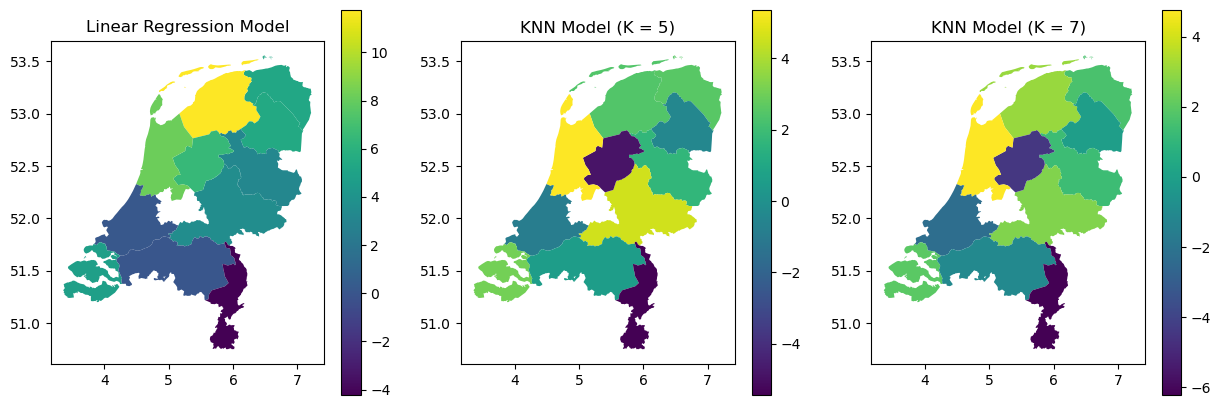

In [ ]:
# Filtering 2012 Data
test_nl = test_nl[test_nl['FYEAR'] == 2012]

fig, axes = plt.subplots(ncols = 3, figsize = (15,5))

test_nl.plot(test_nl["Linear Regression"], legend=True, ax=axes[0])
axes[0].set_title("Linear Regression Model", fontsize=12)

test_nl.plot(test_nl["KNN K = 5"], legend=True, ax=axes[1])
axes[1].set_title("KNN Model (K = 5)", fontsize=12)

test_nl.plot(test_nl["KNN K = 7"], legend=True, ax=axes[2])
axes[2].set_title("KNN Model (K = 7)", fontsize=12)

### References

D. Paudel, H. Boogaard, A. de Wit, S. Janssen, S. Osinga, C. Pylianidis, and I. N. Athanasiadis. [Machine learning for large-scale crop yield forecasting](http://dx.doi.org/10.1016/j.agsy.2020.103016). Agricultural Systems, 187:103016, 2021.